# Graph Visualisation by Physical Simulation

## Abstract

In this notebook, we will investigate a method of graph visualisation that uses two physical phenomena, electrostatic attraction and elasticity, to create aesthetically pleasing visualisations of graph data structures. The interplay between these two phenomena on a graph's nodes should give rise to cycles of equillibrium states where nodes are sufficiently spaced.

## Formulae

The following is the scalar form of Coulomb's law, which we will be using to model the attraction between adjacent nodes:

\begin{align}
F = \frac {k q_1 q_2} {r ^ 2}
\end{align}

Here, $q_1$ and $q_2$ are the quantities of charge of two objects, $r$ is the distance between them and $k$ is the Coulomb's law constant. The appropriate value of this constant for visualising graphs may be determined later, or may be made a function of the graph. The quantity of charge will be analogous to linear functions of a nodes degree and the distance between charges will be the distance between nodes in the plane.

Since we will be representing our graph on the cartesian plane, we ought to derive a vector form of Coulomb's law.

\begin{align}
\textbf {F} = k q_1 q_2 * \frac {1} {|r|^2} * \frac {1} {|r|} * \textbf {r}
\implies \textbf {F} = \frac {k q_1 q_2} {|r| ^ 3} * \textbf {r}
\end{align}

Where $r$ is the displacement vector from one node to another.

The other phenomena utilised in this technique is Hooke's law, given by:

\begin{align}
F = mx
\end{align}

Here, $m$ is the elasticity constant and $x$ is the extension of an object experiencing the force, $F$. Like $k$, $m$ may be a set constant, or it may be a function of the graph. We can derive a vector form for this equation:

\begin{align}
\textbf {F} = m \textbf {x}
\end{align}

We will be using the force, $F_{ij}$, as given by Coulomb's law to calculate an update vector $x_{ij}$ for a node, $i$ , and each of its neighbours, $j$. The sum of these extension vectors will then be added to the nodes position vector in the next iteration.

The following are two functions that encapsulate the force and extension calculations.

In [37]:
#Joseph Harrison 2019
import numpy as np

#calculate the attractive force using Coulomb's law
#r is a numpy array like object
def coulombs_law(k, q1, q2, r):
    r_norm = np.linalg.norm(r)
    return (k * q1 * q2 / r_norm ** 3) * r

#calculate an update vector according to Hooke's law
#F is a numpy array like object
def hookes_law(F, m):
    return (1 / m) * F

#setting some arbitrary parameters
k = 3
q1, q2 = 1, 2
p1, p2 = np.array([5, 4]), np.array([1, 2])
m = 5

print(f'update for node 1: {hookes_law(coulombs_law(k, q1, q2, p2 - p1), m)}')
print(f'update for node 2: {hookes_law(coulombs_law(k, q2, q1, p1 - p2), m)}')

update for node 1: [-0.05366563 -0.02683282]
update for node 2: [0.05366563 0.02683282]


## Graph Representation and Update Algorithm

Graphs will be stored as a linked data structure containing object of a node class. The node class will contain a degree property method, a position vector attribute, as well as a dictionary object attribute linking neighbouring node objects to their corresponding weights. The update vector can be calculated using the update property. This will set a new position vector attribute that will replace the old one when an iteration ending signal is sent through the graph. The following is the definition of the node class, as well as the creation of a simple weighted graph.

In [117]:
#Joseph Harrison 2019

class Node:
    
    def __init__(self, p):
        #position vector
        self.p = p
        #neighbours and their weights
        self.N = dict()
    
    #returns the degree of this node
    @property
    def degree(self):
        return len(self.N)
    
    @property
    def update(self):
        new_p = np.array(self.p)
        for n in self.N:
            #k will be a the weight
            k = self.N[n]
            #q1 and q2 are the reciprocals of the degrees
            q1 = 1 / self.degree
            q2 = 1 / n.degree
            #displacement vector
            r = self.p - n.p
            #avoid division by zero
            if np.linalg.norm(r) == 0:
                continue
            #m is the degree of this node
            m = self.degree
            #calculating the update vector
            new_p += hookes_law(coulombs_law(k, q1, q2, r), m)
        #this is kept as a seperate attribute until a signal
        #representing the end of an iteration is passed through
        #the graph
        self.new_p = new_p
        
    @property
    def end_iteration(self):
        self.p = self.new_p

a = Node(np.array([3, 2], dtype=float))
b = Node(np.array([2, 1], dtype=float))
c = Node(np.array([6, 2], dtype=float))
#the edge from a to b has a weight of 3
a.N[b] = 3
a.N[c] = 2
b.N[b] = 1
b.N[a] = 2
c.N[b] = 4

#complete 5 iterations of this algorithm
for i in range(5):
    print(f'iteration {i + 1}')
    #update the graph position vectors
    for n in [a, b, c]:
        n.update

    #signal iteration end
    for n in [a, b, c]:
        n.end_iteration
        print(n.p)
    
#we won't need this graph, it's just a demo
del a; del b; del c

iteration 1
[3.07702697 2.13258252]
[1.91161165 0.91161165]
[6.11413441 2.0285336 ]
iteration 2
[3.1137988  2.22965155]
[1.8510231  0.84813483]
[6.21635706 2.05570174]
iteration 3
[3.13432011 2.31156191]
[1.80287596 0.79546033]
[6.31032086 2.08169462]
iteration 4
[3.14591719 2.3843299 ]
[1.76235664 0.74932141]
[6.39785392 2.10667285]
iteration 5
[3.15195257 2.45072362]
[1.72715401 0.70772106]
[6.48012507 2.13076323]


The following is a function that takes as input a dictionary and limits on the x and y cooridnates of generated position vectors and returns a dictionary containing node labels and node objects. In addition, we have a procedure that conducts the update algorithm n times.

In [118]:
#Joseph Harrison 2019

#produce a table linking node labels to node objects
def make_graph(graph_dict, x_max, y_max):
    key_node_table = {}
    #create the node objects
    for key in graph_dict:
        #create random position vector
        x = np.random.random() * (2 * x_max) - x_max
        y = np.random.random() * (2 * y_max) - y_max
        p = np.array([x, y])
        key_node_table[key] = Node(p)
    #link the nodes together
    for key in graph_dict:
        for neighbour_key, weight in graph_dict[key]:
            key_node_table[key].N[key_node_table[neighbour_key]] = weight
    return key_node_table

#run the update algorithm n times
def update_algorithm(n, nodes):
    for _ in range(n):
        for node in nodes:
            node.update
        
        for node in nodes:
            node.end_iteration

#example graph
graph_dict = {'a' : [('b', 3), ('c', 2)],
              'b' : [('c', 2), ('d', 1)],
              'c' : [('a', 4), ('b', 2)],
              'd' : [('a', 2), ('b', 1), ('d', 4)]}

key_node_table = make_graph(graph_dict, 5, 5)
nodes = list(key_node_table.values())

print('before:')
for key, node in key_node_table.items():
    print(f'node: {key} position vector: {node.p}')

#running algorithm 20 times
update_algorithm(20, nodes)

print('after:')
for key, node in key_node_table.items():
    print(f'node: {key} position vector: {node.p}')

before:
node: a position vector: [-4.09180729  2.95776645]
node: b position vector: [-2.82214117 -2.18163592]
node: c position vector: [ 2.68666339 -3.70277084]
node: d position vector: [4.84180171 1.42950085]
after:
node: a position vector: [-4.18814439  3.24455238]
node: b position vector: [-2.98096708 -2.15263167]
node: c position vector: [ 2.89973532 -3.81544159]
node: d position vector: [4.88166614 1.43106596]


## Plotting Node Position Vectors

I will be using the Python Pyplot library to plot position vectors.

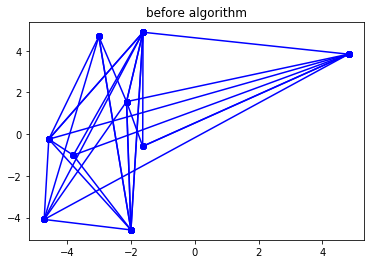

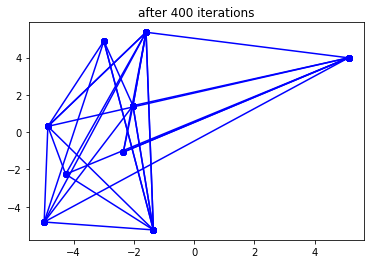

In [143]:
import matplotlib.pyplot as plt

keys = list('abcdefghi')
n = 400

#example graph
graph_dict = {key : [(np.random.choice([k for k in keys if k != key]), 
                      np.random.random())
                      for _ in range(np.random.randint(1, len(keys)))]
              for key in keys}

key_node_table = make_graph(graph_dict, 5, 5)

#plot the graph
for key, node in key_node_table.items():
    for neighbour in node.N:
        plt.plot([node.p[0], neighbour.p[0]], [node.p[1], neighbour.p[1]],'-bo' , label=key)
plt.title('before algorithm')
plt.show()

update_algorithm(n, key_node_table.values())

#plot the new graph
for key, node in key_node_table.items():
    for neighbour in node.N:
        plt.plot([node.p[0], neighbour.p[0]], [node.p[1], neighbour.p[1]],'-bo' , label=key)

plt.title(f'after {n} iterations')
plt.show()

## Conclusion

The algorithm is successful in improving the visulation of poorly spaced nodes, but often adds a negligable decrease or increase in clarity to otherwise sufficient visulations.